<h1>
Using the scipy.optimize library
</h1>    
In this example, our primary goal is to demonstrated how two important functions in the **scipy.optimize** library are used.  Along the way, we will also learn a bit about python syntax and text formatting.

In [11]:
# standard import statements
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as opt

# jupyter-specific display instructions
%config InlineBackend.figure_format = 'retina'

# my personal defaults
mpl.rcParams['figure.figsize'] = (5.5, 3.5)
mpl.rcParams['font.size'] = 10
mpl.rcParams['lines.linewidth'] = 3

Next, we will use pandas to read the excel file containing our data.  The call to pd.read_excel returns a Pandas dataframe.  The call to .head() shows us the overall structure of the dataframe, including the naames of the columns, which we see are called 'x' and 'y'.

In [2]:
# read data from excel file
excel_file = 'data/demo-intro-jupyter-pandas.xlsx'
mydata = pd.read_excel(excel_file)

# extract into numpy arrays
x = np.array(mydata['x'])
y = np.array(mydata['y'])

It is usually a good idea -- before thinking about developing a model and fitting that model -- to first simply visualize your data in "raw" form.  This isn't typically something you would include in a report, so it doesn't have to be super-pretty, but it is usually an essential step to do in your notebook.

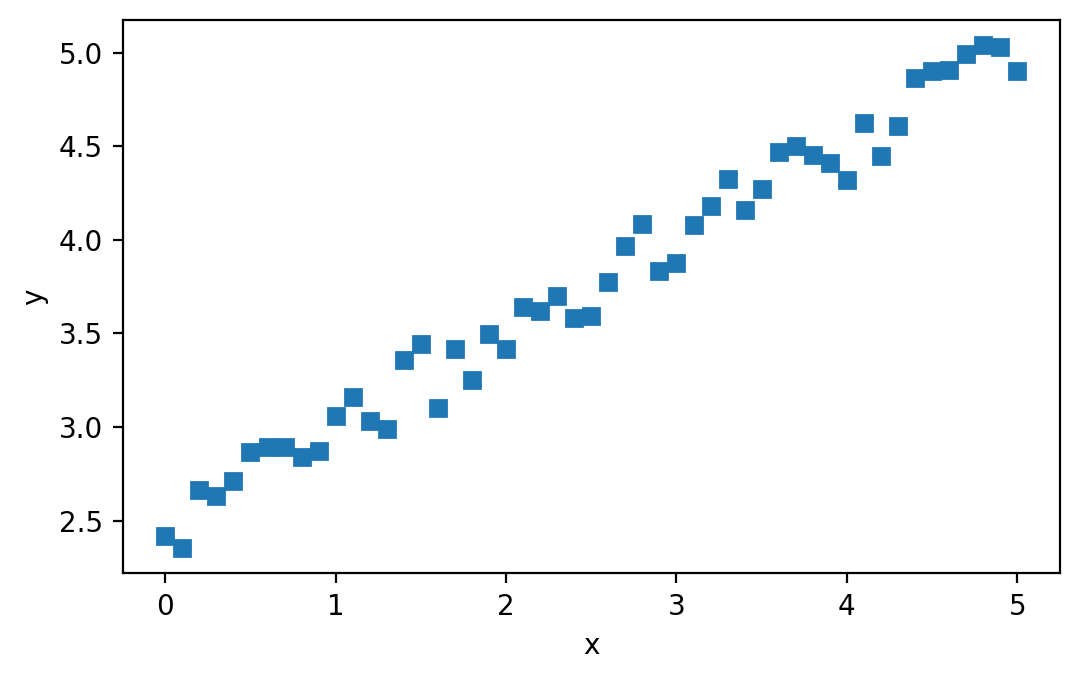

In [3]:
# plot data
fig, ax = plt.subplots()
ax.plot(x, y, 's')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()
plt.show()

Next we will choose and define a model that might fit the data.  This data looks pretty linear, so we will simply choose a line.

Note that the independent variable is the first argument, followed by each of the parameters as separate arguments.  This was a *choice*, and I could have defined the function so that the parameters occurred in a different order.  We'll see why I made this particular choice a bit later.

In [12]:
def line(x, a, b):
    return a + b*x

Next we will define a residual funciton, defined in class as "the sum of the squares of the difference between the model and the data."  

Note that the residual function accepts the paramters first, *as a vector,* followed by the values of the independent variable, followed by the values of the dependent variable.  This is the way the minimization function that we'll use below expects these arguments to be ordered.

Note also that in the call to our model function, we ***unroll*** the vector into its individual components using the star operator.  Both of these specific syntax structures are imposed on us by the libraries we will be using (as can be seen from the documentation).

In [5]:
# define residual function
def ssres(params, x, y):
    model = line(x, *params)     # get predicted values
    resid = y - model            # calculate residual
    ssres = sum(resid**2)        # sum the squares
    return ssres

Next, we will minimize the residual function using the **minimize()** function in the scipy.optimize library.

In [6]:
# call minimize() to fit model to data
pguess = [2.5,0.5]
result = opt.minimize(ssres, pguess, args=(x, y))
pfit   = result.x
display(pfit)

array([2.47784404, 0.51518291])

Finally, we will obtin the predicted values of the dependent variable from the fitted model paramters, and plot that fitted model together with the original data.  

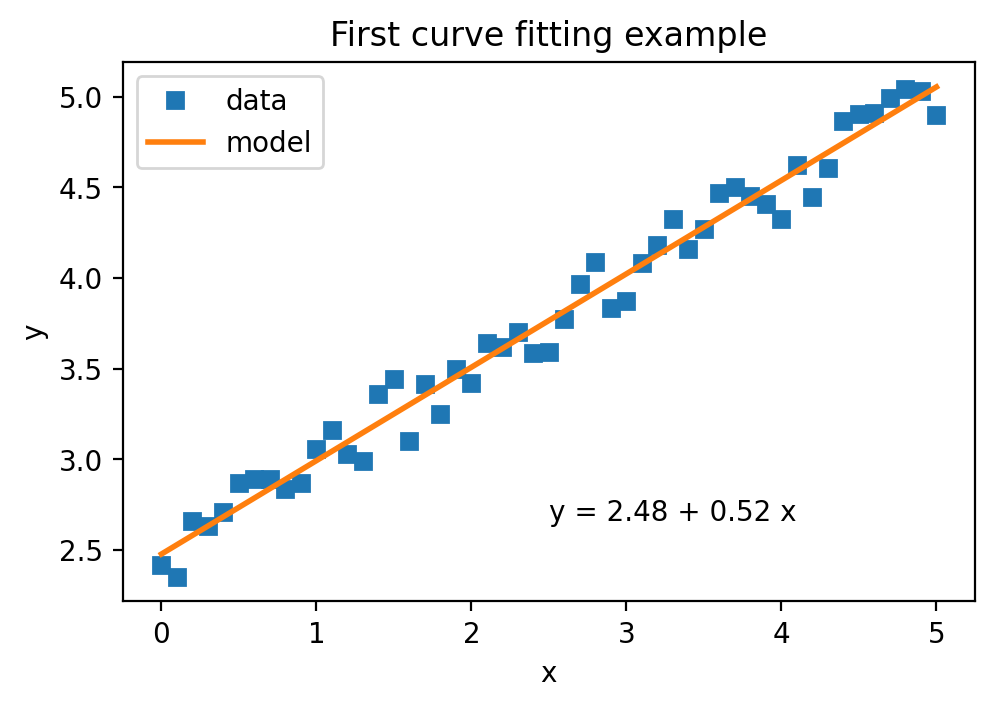

In [7]:
# getting predicted values -- method 1
a, b = pfit
pred = line(x, a, b)  

# getting predicted values -- method 2
pred = line(x, *pfit)

# plot data and fitted model together
fit, ax = plt.subplots()
ax.plot(x, y, 's', label='data')
ax.plot(x, pred, '-', linewidth=2, label='model')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('First curve fitting example')
ax.text(.5, .15, 'y = %1.2f + %1.2f x' % (pfit[0], pfit[1]), transform=ax.transAxes)
ax.legend(loc='best')
fig.tight_layout()
plt.show()

You might notice that except for the call to our specific model, the contents of ssres() were entirely generic.  Wouldn't it be handy if we didn't have to define almost-identical functions of this type every time we wanted to fit a curve?  Well, it turns out that scipy.optimize has already made this possible using the **curve_fit()** function.  Observe:

In [8]:
# using curve_fit()
pfit, pcov = opt.curve_fit(line, x, y)
display(pfit)

array([2.47784403, 0.51518292])

This gives exactly the same result as before.  In addition, it returns something called the *covariance* matrix, which is related to the uncertainties in the parameter estimates.  In particular, the square roots of the diagonal components of the covariance matrix are the *standard deviations* in the range of likely parameter values.  Since two standard deviations contain 95% of likely values, we can establish 95% confidence intervals in our predicted parameter values if we multiply these numbers by two.  Then we can print out a nice summary our fit results.

In [9]:
perr = 2*np.sqrt(np.diag(pcov))   # absolute uncertainty
ppct = perr / np.abs(pfit)        # relative uncertainty

print("fit results")
print("----------------")
print("a = %4.2f +- %4.2f  (%4.2f%%)" % (pfit[0], perr[0], ppct[0]*100))
print("b = %4.2f +- %4.2f  (%4.2f%%)" % (pfit[1], perr[1], ppct[1]*100))

fit results
----------------
a = 2.48 +- 0.06  (2.54%)
b = 0.52 +- 0.02  (4.22%)


The operations we have seen above will be needed over and over during this class.  To help you out, I've created a helper function in our class library called **fit_and_plot()** that will fit a specified model to a data set, display the fitted model, and summarize the values and uncertainties of the fit parameters.

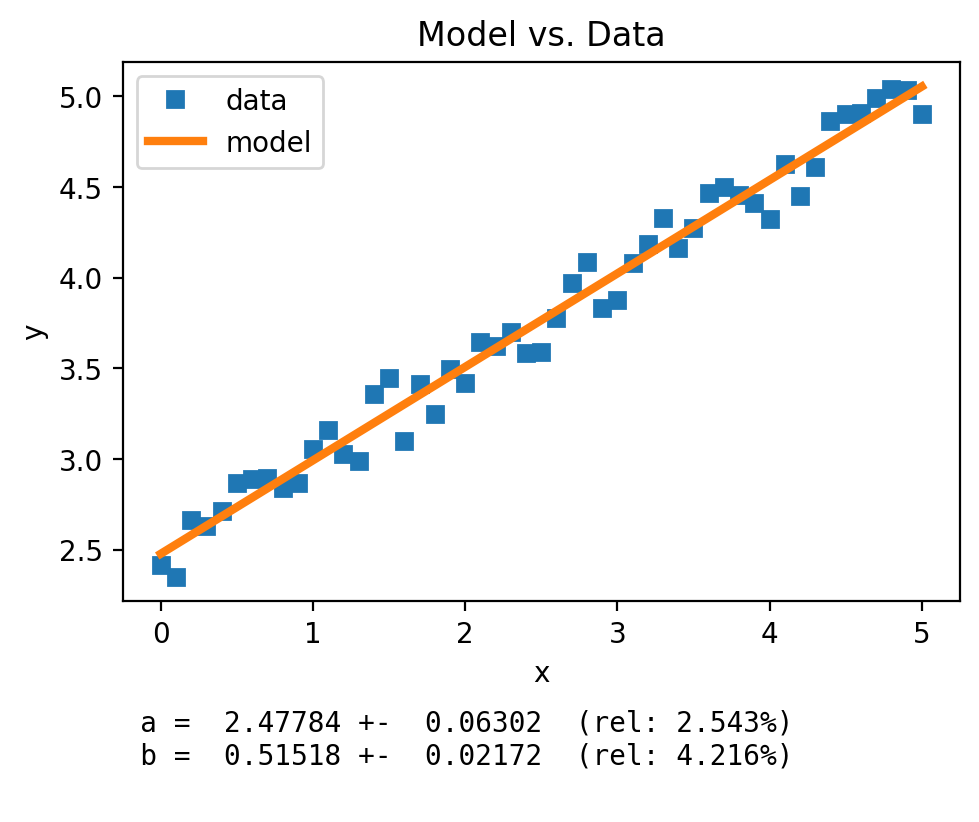

In [13]:
import classlib4334
pfit, perr = classlib4334.fit_and_plot(line, x, y)

This function also has lots of optional arguments, allowing you to change the labels on the axes, the title, and even save a copy of the file to 

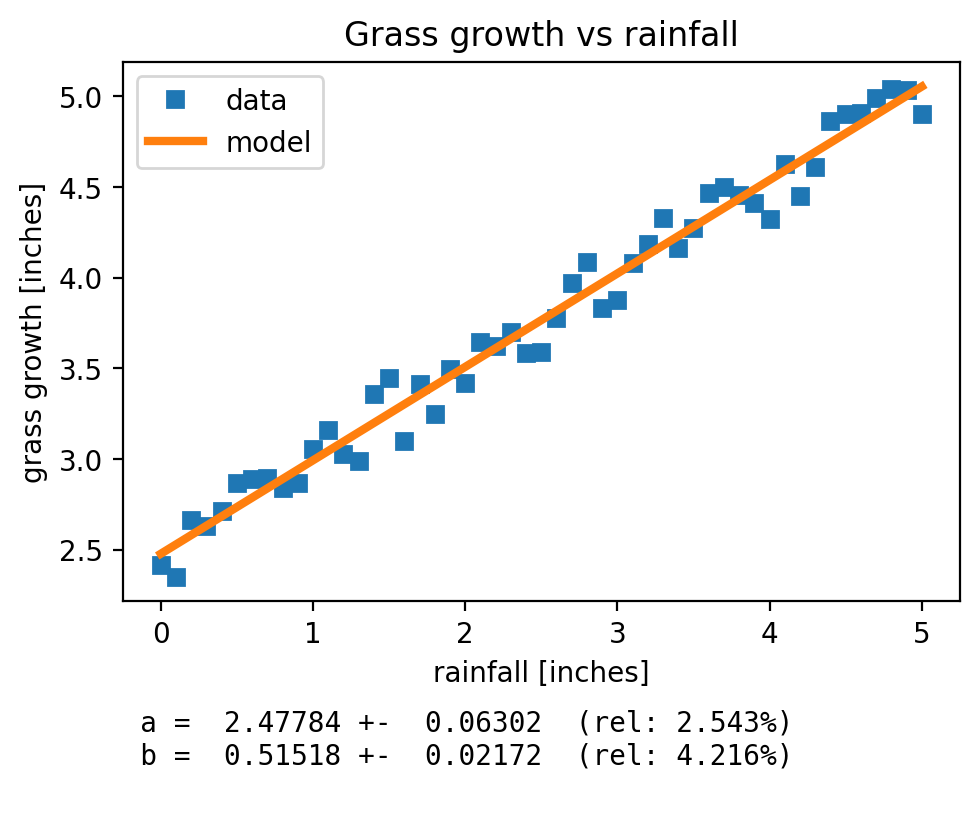

In [15]:
pfit, perr = classlib4334.fit_and_plot(
    line, x, y,
    xlabel = "rainfall [inches]",
    ylabel = "grass growth [inches]",
    title = "Grass growth vs rainfall",
    filename = "demo-02a-graph.pdf"
)

## Going Further (optional enrichment content)

If you are interested, let's explore the covariance matrix a bit more.   Let's start by printing it out

In [16]:
print(pcov)

[[ 0.00099281 -0.00029489]
 [-0.00029489  0.00011796]]


We saw what the diagonal elements meant, but what about the off-diagonal elements?

To gain intuition, it helps to know that mathematically, this covariance matrix is proportional to the inverse of the *Hessian* -- the matrix of all second derivatives -- of the squared error norm $E_2^2(A,B)$ (remember Calculus III, where we set the first derivatives equal to zero to find the critical points, and then used the second derivatives to determine the nature of the critical point?  If you put all the second derivatives into a matrix, you get the Hessian).  Therefore the covariance matrix *indirectly* provides all of the second derivatives of the squared error function at the minimum point.

Before attempting to recover the Hessian, we need to know that -- for reasons I don't understand, the convention in **scipy.optimize** is to scale the relationship by twice the **adjusted mean squared error**, as follows:
$$ C = 2 E_{ams} \times H^{-1} $$
where the adjusted mean-squared error, in turn, is defined via
$$ E_{ams} = \frac{ \sum_{i=1}^{N} \left( f(x_i) - y_i \right) }{N - P}  $$
where, finally, $N$ is the number of points in the data set, and $P$ is the number of parameters in the model.  Whew!

In any case, we can solve for the Hessian in two lines of code, if we know that the **numpy.var()** function allows us to compute the adjusted mean square error in one line.

In [17]:
Eams = np.var(line(x, *pfit) - y, ddof=len(pfit))
hess = np.linalg.inv(pcov/Eams/2)
print(hess)

[[101.9999999  255.00000239]
 [255.00000239 858.50001877]]


Now, if this matrix corresponds to the second derivatives of the objective function at its minimum, then it appears that the concavity of the error landscape is much lower in the A-direction than it is in the B-direction.  And recall that our uncertainties were smaller for B than they were for A.  These two things are connected:  the steeper the error landscape in a given direction, the smaller are the uncertainties in the estimate of that parameter.

Finally, if we want to be really fancy, we can use this information to visualize the shape of the "error landscape" in the vicinity of the optimal parameter values.  Let's see what this looks like:

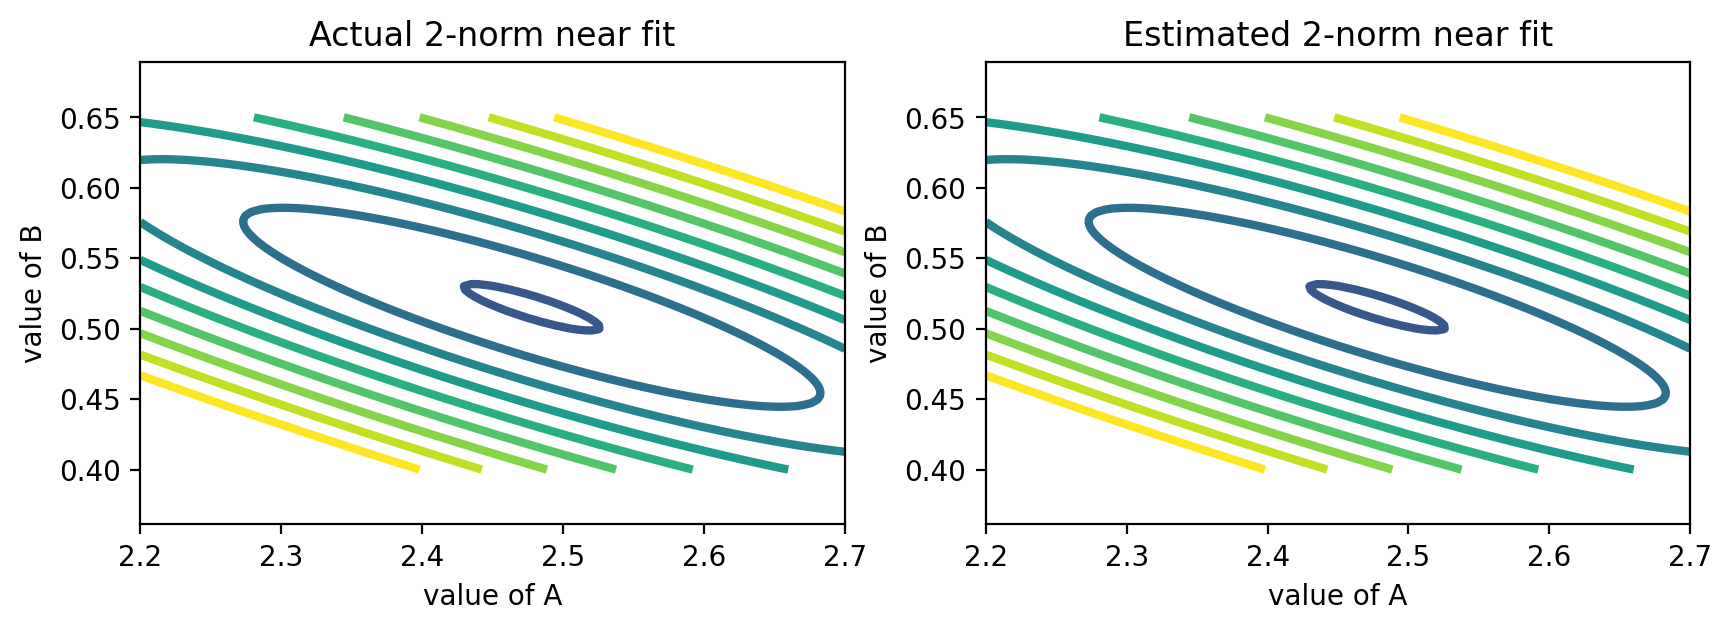

In [18]:
# create a 2D grid of points in the (A,B) parameter space
a = np.linspace(2.2, 2.7, 101)
b = np.linspace(0.4, 0.65, 101)
A, B = np.meshgrid(a, b)

# for each point on this grid, get the actual value of the squared error
E22actual = np.zeros_like(A)
for ii, (arow, brow) in enumerate(zip(A, B)):
    for jj, (a, b) in enumerate(zip(arow, brow)):
        E22actual[ii, jj] = np.sum((line(x, a, b) - y)**2)

# for each point on this grid, use the second derivatives to construct a paraboloid approximation
E22est = np.min(E22actual) + 0.5*hess[0][0]*(A - pfit[0])**2 + 0.5*hess[1][1]*(B - pfit[1])**2 + hess[0][1]*(A-pfit[0])*(B-pfit[1])


# define some level curve values
lcurves = np.linspace(0,3,12)

# create a figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))

# plot the actual objective function
ax1.contour(A, B, np.sqrt(E22actual), lcurves)
ax1.axis("equal")
ax1.set_xlabel("value of A")
ax1.set_ylabel("value of B")
ax1.set_title("Actual 2-norm near fit")

# plot the estimated objective function
ax2.contour(A, B, np.sqrt(E22est), lcurves)
ax2.axis("equal")
ax2.set_xlabel("value of A")
ax2.set_ylabel("value of B")
ax2.set_title("Estimated 2-norm near fit")

fit.tight_layout()
plt.show()

See how well the actual error 2-norm is approximated locally by a quadratic function!  Behold, the power of Taylor series ...

In these figures, we see that the valley in the (A, B) landscape is wider than it is tall. This means we should expect more uncertainty in A than we do in B.  The valley is also a bit tilted, which is what causes the off-diagonal entries in the covariance to be non-zero.  This tilt arises because for the model $y = A + Bx$, **some** of the error that arises when you decrease A can be offset by increasing B.

In summary, the full covariance matrix provides a more nuanced picture of the uncertainties in our estimates than just its diagonal, and in particular, it helps us see when uncertainties in different terms might be correlated.  This **can be an issue** in complex models with lots of terms, but in this class we probably won't worry about it too much again.